# EfficientNetB0 improved

## Description

**Codabench accuracy** : 0.64

**Local test accuracy**: 0.97

**Description**: Introducing ELU and Lion optimizer, Mixed Precision and adding Normalization to EfficientNetB0

**Motivation**: Reducing training time and experimenting with different activation functions and optimizers

## Google Drive - Connecting to the project

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1"
%cd {project_path}
sys.path.append(project_path)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1


## Imports

In [2]:
%load_ext autoreload
%autoreload 2

import utils

import numpy as np
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers

from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras import mixed_precision

In [3]:
# Setting the keras policy to be mixed_float16, to speed up training
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

## Parameters

In [4]:
# We are dealing with an 8-class problem with 96x96 RGB images as input
OUTPUT_SIZE = 8
INPUT_SHAPE = (96,96,3)

## Load Data and Class Weights

In [5]:
# Cleaned dataset loading with a split in train, validation and test datasets,
# besides calculating more accurate class weights used in training
X, y = utils.load_cleaned_dataset()
CLASS_WEIGHTS = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
CLASS_WEIGHTS = {i:CLASS_WEIGHTS[i] for i in range(len(CLASS_WEIGHTS))}
X_train, X_val, X_test, y_train, y_val, y_test = utils.split_dataset(X, y, test_size=0.2, val_size=0.2)

## Model Implementation

In [6]:
# Importing of the model EfficientNetB0 without top layers
efficientNet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
efficientNet.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Model Definition
def build_model():
    # The input layer takes 96x96 RGB images
    input_layer = tfkl.Input(shape=INPUT_SHAPE, name='Input')

    # Definition of augmentation layer used to modify the samples
    augmentation = tfk.Sequential([
        tfkl.RandomFlip('horizontal_and_vertical'),
        tfkl.RandomRotation(0.2),
        tfkl.RandomTranslation(0.2, 0.2),
        tfkl.RandomContrast(0.3)
    ])

    x = augmentation(input_layer)

    # Feeding augmented data into efficientnet
    x = efficientNet(x)

    # GAP, dropout and dense layers for the top of the network
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dropout(0.5)(x)
    x = tfkl.Dense(128)(x)
    x = tfkl.ELU()(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.5)(x)

    # Dense layer as output
    output_layer = tfkl.Dense(OUTPUT_SIZE, activation='softmax', name='Output')(x)

    model = tfk.Model(inputs=input_layer, outputs=output_layer)
    return model

In [8]:
# Model construction
model = build_model()

# Model compilation with Lion with default learning rate, sparse categorical crossentropy
model.compile(optimizer=tfk.optimizers.Lion(),
              loss=tfk.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 3, 3, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,215,083 (16.08 MB)

 Trainable params: 165,256 (645.53 KB)

 Non-trainable params: 4,049,827 (15.45 MB)

## Training

In [9]:
# Training Parameters
EPOCHS = 1000
BATCH_SIZE = 128
PATIENCE = 20

In [10]:
# Early Stopping Implementation
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
callbacks = [early_stopping]

In [11]:
# Actual training with given parameters
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    class_weight=CLASS_WEIGHTS,
                    validation_data=(X_val,y_val)).history

Epoch 1/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 110ms/step - accuracy: 0.3256 - loss: 2.4789 - val_accuracy: 0.7529 - val_loss: 0.8474
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.6945 - loss: 0.9135 - val_accuracy: 0.7989 - val_loss: 0.6032
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7144 - loss: 0.7861 - val_accuracy: 0.7851 - val_loss: 0.6076
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7216 - loss: 0.7627 - val_accuracy: 0.8018 - val_loss: 0.5836
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.7545 - loss: 0.7155 - val_accuracy: 0.8278 - val_loss: 0.5122
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7460 - loss: 0.7255 - val_accuracy: 0.8248 - val_loss: 0.4924
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.7588 - loss: 0.6770 - val_accuracy: 0.8232 - val_loss: 0.4886
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7674 - loss: 0.6520 - val_ac

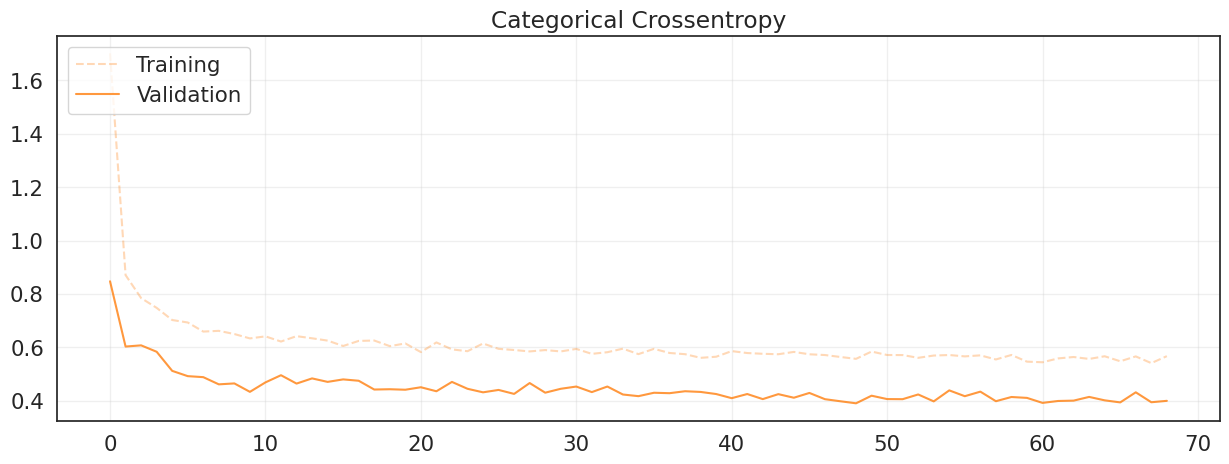

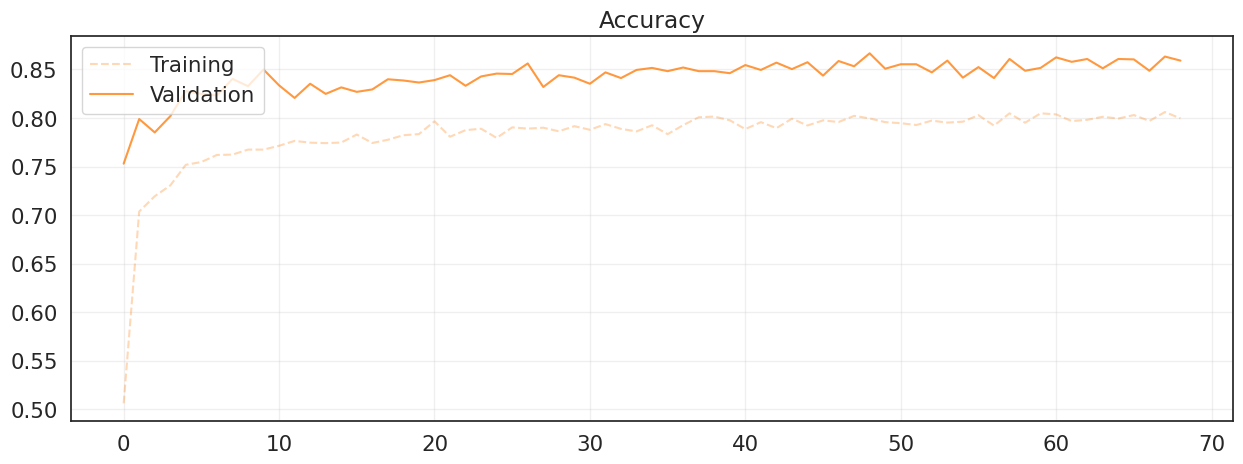

In [12]:
# Plot the loss function and accuracy value over epochs
utils.plot_history(history)

## Save

In [13]:
# Saving the model for testing and submission
accuracy = round(max(history['val_accuracy'])* 100, 2)
model_name = f"efficientnetb0_norm_{accuracy}.keras"
%cd models/
print(f"Saving {model_name}")
model.save(model_name)
%cd ..
print("Model Saved")

/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1/models
Saving efficientnetb0_norm_86.66.keras
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1
Model Saved


## Fine-Tuning


In [14]:
# Setting all the parameters of the network as trainable
model.get_layer('efficientnetb0').trainable = True

# Setting all layers as not trainable
for layer in model.get_layer('efficientnetb0').layers:
    layer.trainable = False

# Setting all the actually trainable layers to trainable
for i, layer in enumerate(model.get_layer('efficientnetb0').layers):
    if isinstance(layer, tfkl.Conv2D) or isinstance(layer, tfkl.SeparableConv2D) or isinstance(layer, tfkl.DepthwiseConv2D):
        layer.trainable = True

# Freezing up to a certain depth
FREEZE_DEPTH = 162
for layer in model.get_layer('efficientnetb0').layers[:FREEZE_DEPTH]:
    layer.trainable = False

# Print model details
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 3, 3, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,380,345 (16.71 MB)

 Trainable params: 3,295,140 (12.57 MB)

 Non-trainable params: 919,943 (3.51 MB)

 Optimizer params: 165,262 (645.57 KB)

In [15]:
# Custom learning rate
FT_LEARNING_RATE = 1e-5

In [16]:
# Model compilation with Lion and sparse categorical crossentropy
model.compile(optimizer=tfk.optimizers.Lion(FT_LEARNING_RATE),
                loss=tfk.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

In [17]:
# Actual training with given parameters
finetuned_history = model.fit(x=X_train,
                    y=y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    validation_data=(X_val,y_val)).history

Epoch 1/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.8047 - loss: 0.5442 - val_accuracy: 0.8717 - val_loss: 0.3544
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.8502 - loss: 0.4351 - val_accuracy: 0.8892 - val_loss: 0.3011
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8716 - loss: 0.3718 - val_accuracy: 0.8921 - val_loss: 0.2925
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8944 - loss: 0.3229 - val_accuracy: 0.8917 - val_loss: 0.2766
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9010 - loss: 0.2978 - val_accuracy: 0.9009 - val_loss: 0.2585
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.9119 - loss: 0.2622 - val_accuracy: 0.9143 - val_loss: 0.2262
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9180 - loss: 0.2496 - val_accuracy: 0.9260 - val_loss: 0.1990
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9219 - loss: 0.2272 - va

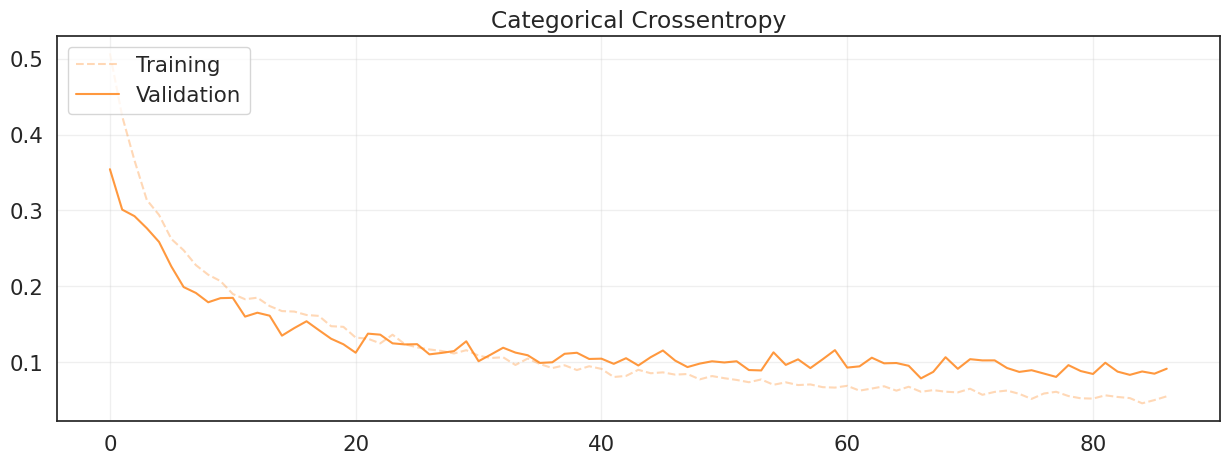

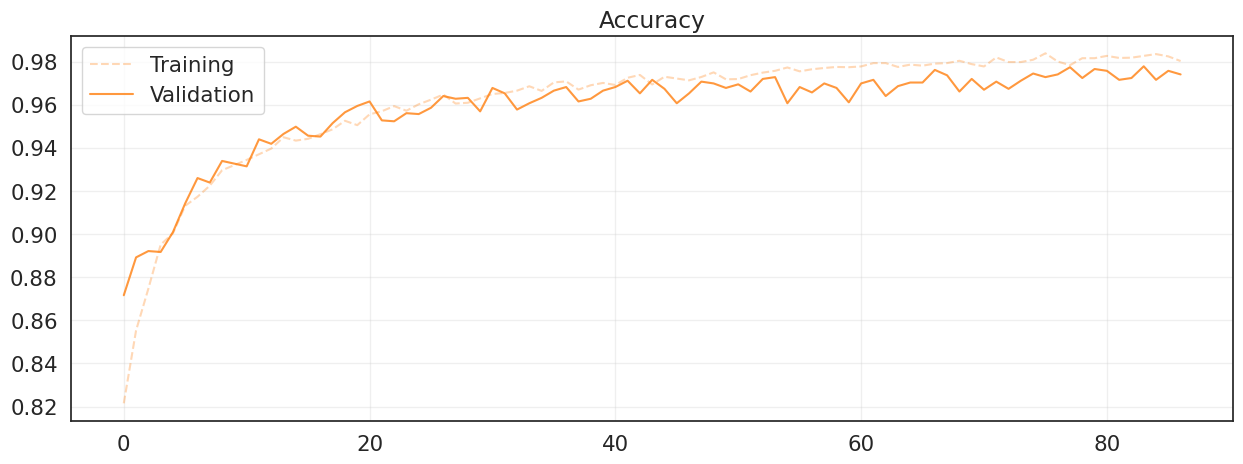

In [18]:
# Plotting the loss function and accuracy value over epochs
utils.plot_history(finetuned_history)

## Save the Model

In [19]:
# Saving the model for testing and submission
accuracy = round(max(finetuned_history['val_accuracy'])* 100, 2)
model_name = f"efficientnetb0_ELU_MP_norm_ft_{accuracy}.keras"
%cd models/
print(f"Saving {model_name}")
model.save(model_name)
%cd ..
print("Model Saved")

/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1/models
Saving efficientnetb0_ELU_MP_norm_ft_97.78.keras
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1
Model Saved


## Test Prediction and Final Evaluation

In [20]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=1)

In [21]:
# Calculate and display test set accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(y_test, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(y_test, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(y_test, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

Accuracy score over the test set: 0.9649
Precision score over the test set: 0.9659
Recall score over the test set: 0.9649
F1 score over the test set: 0.965
